<a href="https://colab.research.google.com/github/TiffPlourde/Statistical-Methods-in-ML/blob/main/Image_Denoising_using_Belief_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoising
We will consider images as matrices of size $\sqrt{n} \times \sqrt{n}$. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels.

# Image Preparation
Below is code for loading and preparing the image data.

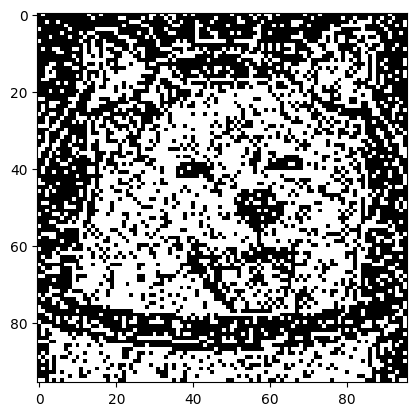

In [ ]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm
filename, url = "3vaef0cog4f61.png", "https://i.redd.it/3vaef0cog4f61.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = np.array(img2)
    return (img2[:96,11:107] > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (2 * swap - 1)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(-1 * img_noisy, cmap='gray')



# BP-Loopy Algorithm

Initialization:

The Loopy-BP algorithm iteratively updates the messages of each node through a sum-product operation. The **sum-product** operation computes the joint inbound message through multiplication, and then marginalizes the factors through summation. This is in contrast to the **max-product** BP, which computes the maximum a-posteriori value for each variable through taking the maximum over variables.

For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$.

(Aside: for continuous cases, $m_{i \rightarrow j}(x_j)$ is a real valued function of $x_j$. We only need to deal with the discrete case here.)

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$:
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_j y_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Marginalize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in \mathcal N(i)} m_{j \rightarrow i}(x_i).
$$

# Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [ ]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

In [ ]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

In [ ]:
def get_message(node_from, node_to, messages):
    """
    arguments:
      int node_from: in [0,num_nodes) index of source node
      int node_from: in [0,num_nodes) index of target node
      float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
      float array y: (num_nodes,) observed pixel values
      float J: clique coupling strength constant
      float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to
    node_to
    """
    start_node = node_from
    term_i = node_to
    n_j = get_neighbors_of(start_node)
    n_j.remove(term_i)


    t1 = 1
    t2 = 1
    for k in n_j:
      t1 = t1 * messages[0, k, start_node]
      t2 = t2 * messages[1, k, start_node]


    t_1 = np.exp(beta * 1 * y[start_node]) * np.exp(J * 1 * 1) * t1 + np.exp(beta * -1 * y[start_node]) * np.exp(J * 1 * -1) * t2
    t_2 = np.exp(beta * 1 * y[start_node]) * np.exp(J * -1 * 1) * t1 + np.exp(beta * -1 * y[start_node]) * np.exp(J * -1 * -1) * t2

    return np.array([t_1, t_2])

In [ ]:
def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):

            m_new = get_message(node_from, node_to, messages)

            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * messages[:, node_from, node_to]

    return messages






In [ ]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [ ]:
def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """
    beliefs = np.zeros([2, num_nodes])

    for node in range(num_nodes):

        n_i = get_neighbors_of(node)
        m_n_1 = np.prod(np.array([messages[0, i, node] for i in n_i]))
        m_n_2 = np.prod(np.array([messages[1, i, node] for i in n_i]))
        m_1 = np.exp(beta * 1 * y[node]) * m_n_1
        m_2 = np.exp(beta * -1 * y[node]) * m_n_2
        b_1 = m_1 / (m_1 + m_2)
        b_2 = m_2 / (m_1 + m_2)
        beliefs[:,node] = [b_1, b_2]

    return beliefs


# call update_beliefs() once
beliefs = update_beliefs(init_message)

Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white.

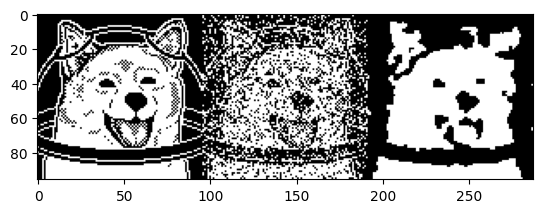

In [ ]:
pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)

plt.imshow(np.hstack([img_true, -1*img_noisy, img_out]), cmap='gray')

# The Affects of Momentum on BP

We will experimentally investigate how momentum affects the characteristics of convergence. In other words, we are observing the affects of the step_size parameter.


In [ ]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for i in range(max_step):
        init_message = step_bp(step_size, messages)
        beliefs = update_beliefs(init_message)
        pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
        img_out = pred.reshape(img_true.shape)
        images.append(img_out)


    return images

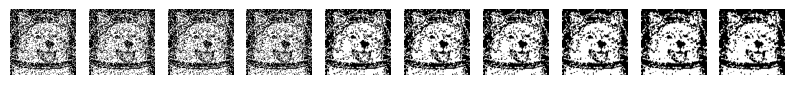

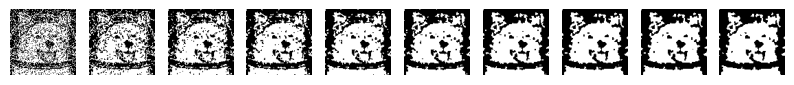

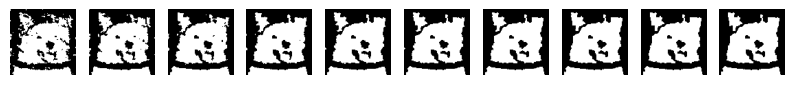

In [ ]:
def plot_series(images):

  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()


max_step = 10
for step_size in [0.1, 0.3, 1.0]:
    plot_series(test_trajectory(step_size, max_step))

As we increase J, an increase in noise helps preserve details and prevent the over-smoothing/loss in detail of the image.

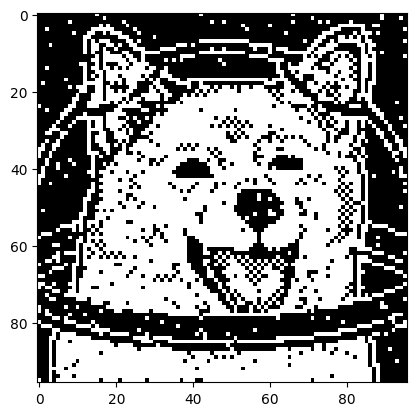

In [ ]:
plt.imshow(-1 * gen_noisyimg(img_true, 0.05), cmap='gray')

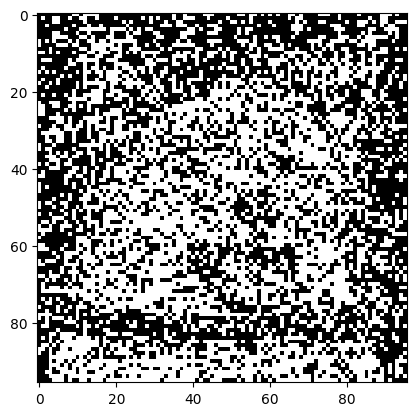

In [ ]:
plt.imshow(-1 * gen_noisyimg(img_true, 0.3), cmap='gray')

 Performing image denoising on images with noise levels  0.05  and  0.3  using using  J=0.1 ,  J=0.5 ,  J=1.0 , and  J=5.0 . Set step size to 0.8 and max_step to 5.

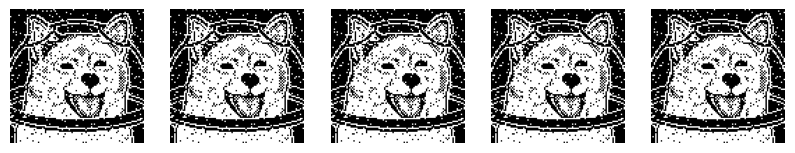

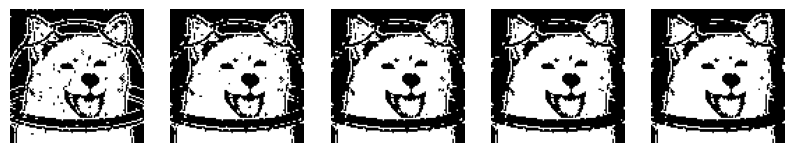

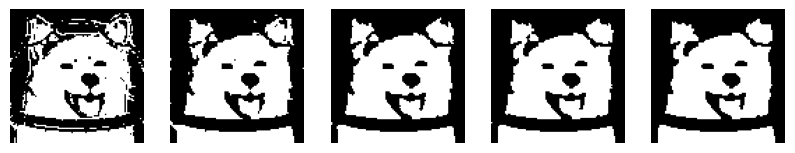

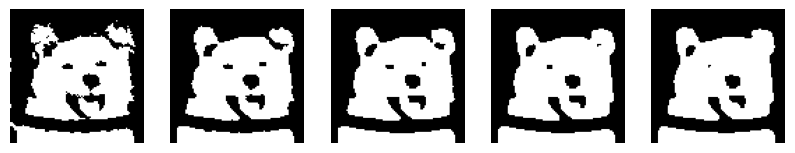

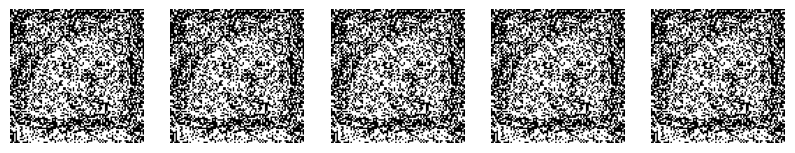

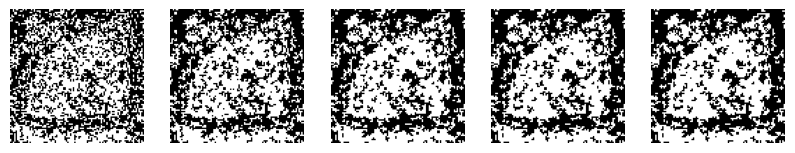

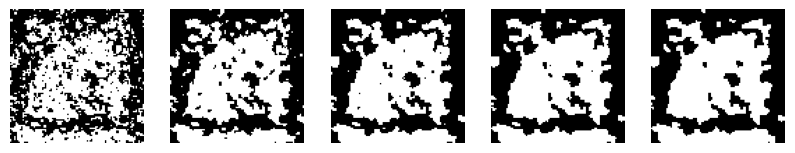

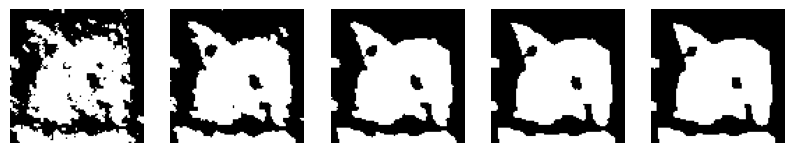

In [ ]:
max_step = 5
step_size = 0.8
for noise0 in [0.05, 0.3]:
    img_noisy = gen_noisyimg(img_true, noise0)
    y = img_noisy.reshape([img_true.size, ])
    for J0 in [0.1, 0.5, 1.0, 5.0]:
        J = J0
        plot_series(test_trajectory(step_size, max_step))